In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
#from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

#import pickle

In [22]:
colNames = list(range(1024))
colNames.append("label")
df = pd.read_csv('../qsar_oral_toxicity.csv', sep=';',names=colNames)

In [23]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,negative
8988,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,negative
8989,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,negative
8990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative


In [24]:
#label 1 is positive; otherwise negative
df = pd.get_dummies(df)
df.drop("label_negative",1,inplace=True)
df = df.rename({"label_positive":"label"},axis=1)

In [25]:
df[df["label"]==1].shape
#according to paper's table, this means we have VT data, with ECFP_1024_02 or ECFP_1024_02R

(741, 1025)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8992 entries, 0 to 8991
Columns: 1025 entries, 0 to label
dtypes: int64(1024), uint8(1)
memory usage: 70.3 MB


In [27]:
df["label"].value_counts()

0    8251
1     741
Name: label, dtype: int64

In [28]:
#train, test split
train, test=train_test_split(df, test_size=0.3, random_state=1)
train.reset_index(drop=True, inplace=True)

In [29]:
#######<--

In [30]:
#######-->

In [31]:
train["label"].value_counts()

0    5765
1     529
Name: label, dtype: int64

In [32]:
#!pip install imblearn

In [33]:
###<--

In [34]:
#upsampling: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t10
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=12, sampling_strategy=1)#'minority')
#X_train, y_train = smote.fit_resample(train.drop(["label"],1), train["label"])

#plot_2d_space(X_train, y_train, 'SMOTE over-sampling')
#X_test=test.drop(["label"],1)
#y_test=test["label"]

In [35]:
###-->

In [36]:
#y_train.value_counts()

In [37]:
#y_train[y_train==0].shape

In [38]:
X_train=train.drop(["label"],1)
y_train=train["label"]

# Optimizing

In [39]:
#https://stackoverflow.com/questions/58815016/cross-validating-with-imblearn-pipeline-and-gridsearchcv

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

def imb_pipeline(clf, X, y, params):

    model = Pipeline([
        ('classification', clf)
    ])
    #optimizing bal_accuracy instead of accuracy score bc we didnt upsampled and have a imbalanced training set; can check that accuracy score later, make suree it is low
    score={'BALANCED_ACCURACY':'balanced_accuracy', 'RECALL':'recall', 'F1':'f1'}

    gcv = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring=score, n_jobs=12, refit='BALANCED_ACCURACY')
    gcv.fit(X, y)

    return gcv

def print_scores(grid_result):
    print("Best ACCURACY: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_BALANCED_ACCURACY']
    stds = grid_result.cv_results_['std_test_BALANCED_ACCURACY']
    means2 = grid_result.cv_results_['mean_test_RECALL']
    stds2 = grid_result.cv_results_['std_test_RECALL']
    means3 = grid_result.cv_results_['mean_test_F1']
    stds3 = grid_result.cv_results_['std_test_F1']
    params = grid_result.cv_results_['params']
    print("BALANCED_ACCURACY, RECALL, F1 with PARAMS")
    for mean, std, mean2, std2, mean3, std3, param in zip(means, stds, means2, stds2, means3, stds3, params):
        print("%f (%f), %f (%f), %f (%f) with: %r" % (mean, std, mean2, std2, mean3, std3, param))

In [40]:
from scipy.stats import loguniform

classifiers = LogisticRegression(C=1.0, penalty='l2',
                     random_state=None, tol=0.0001, verbose=0,
                     warm_start=False)

#see solver in https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
params = [{'classification__penalty':['elasticnet'],
          'classification__solver':['saga'],
          'classification__C': loguniform(1e-5, 100)},
          {'classification__penalty':['none','l2'],
          'classification__solver':['newton-cg', 'lbfgs', 'sag','saga'],
          'classification__C': loguniform(1e-5, 100)},
          {'classification__penalty':['l1'],
          'classification__solver':('liblinear','saga'),
          'classification__C': loguniform(1e-5, 100)}
         ]

        
    
#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(classifiers, X_train, y_train, params) 

#print
print_scores(grid_result)

Best ACCURACY: 0.711567 using {'classification__C': 6.67912745803965, 'classification__penalty': 'l2', 'classification__solver': 'lbfgs'}
BALANCED_ACCURACY, RECALL, F1 with PARAMS
0.711567 (0.027586), 0.466846 (0.055584), 0.479554 (0.041892) with: {'classification__C': 6.67912745803965, 'classification__penalty': 'l2', 'classification__solver': 'lbfgs'}
nan (nan), nan (nan), nan (nan) with: {'classification__C': 0.00044815002061388763, 'classification__penalty': 'elasticnet', 'classification__solver': 'saga'}
nan (nan), nan (nan), nan (nan) with: {'classification__C': 0.6565560393907693, 'classification__penalty': 'elasticnet', 'classification__solver': 'saga'}
0.711083 (0.018369), 0.483917 (0.038631), 0.448422 (0.025037) with: {'classification__C': 0.07014423578143242, 'classification__penalty': 'none', 'classification__solver': 'lbfgs'}
nan (nan), nan (nan), nan (nan) with: {'classification__C': 29.755767441386233, 'classification__penalty': 'elasticnet', 'classification__solver': 's

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [41]:
from scipy.stats import randint

classifiers = RandomForestClassifier(n_estimators=50)

#some selected params in https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {'classification__n_estimators': randint(10, 1000), 'classification__max_depth': randint(10,100),
         'classification__criterion':('gini', 'entropy'), 'classification__max_features':('auto', 'sqrt', 'log2')}
    
#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(classifiers, X_train, y_train, params) 

#print
print_scores(grid_result)

Best ACCURACY: 0.691493 using {'classification__criterion': 'gini', 'classification__max_depth': 51, 'classification__max_features': 'auto', 'classification__n_estimators': 850}
BALANCED_ACCURACY, RECALL, F1 with PARAMS
0.689355 (0.017553), 0.389290 (0.036347), 0.516542 (0.033232) with: {'classification__criterion': 'gini', 'classification__max_depth': 90, 'classification__max_features': 'auto', 'classification__n_estimators': 915}
0.638064 (0.019741), 0.283414 (0.040176), 0.414348 (0.046409) with: {'classification__criterion': 'gini', 'classification__max_depth': 12, 'classification__max_features': 'sqrt', 'classification__n_estimators': 824}
0.667736 (0.015098), 0.343971 (0.030009), 0.478376 (0.033535) with: {'classification__criterion': 'gini', 'classification__max_depth': 50, 'classification__max_features': 'log2', 'classification__n_estimators': 668}
0.645156 (0.010969), 0.296730 (0.022102), 0.433924 (0.025452) with: {'classification__criterion': 'gini', 'classification__max_depth

In [42]:
import numpy
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import loguniform

#setting up NN model 
def setUpModel(n1, n2, lr=0.001, momentums=0.9):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=momentums, learning_rate=lr),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=100, epochs=100)
# define the grid search parameters
neurons1 = (5, 10, 15, 20)
neurons2 = (5, 10, 15, 20)
lr = [0.005,0.01,0.05,0.1]
momentum = [0.1, 0.4,0.7,0.9,0.99]
params = {"classification__n1":randint(5,15), "classification__n2":randint(5,15),
         "classification__lr":loguniform(0.0001,10), "classification__momentums": uniform(0.01,0.999999)}

#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(Kmodel, X_train, y_train, params) 

#print
print_scores(grid_result)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best ACCURACY: 0.720099 using {'classification__lr': 3.388001161548313, 'classification__momentums': 0.07785545260401411, 'classification__n1': 6, 'classification__n2': 10}
BALANCED_ACCURACY, RECALL, F1 with PARAMS
0.500148 (0.000297), 0.594231 (0.485302), 0.088561 (0.072372) with: {'classification__lr': 0.00011998912369216542, 'classification__momentums': 0.07890272532581599, 'classification__n1': 14, 'classification__n2': 5}
0.715737 (0.011886), 0.463882 (0.025354), 0.510299 (0.030323) with: {'classification__lr': 0.6738486038824141, 'classification__momentums': 0.20712523392409424, 'classification__n1': 8, 'classification__n2': 13}
0.577130 (0.061734), 0.159610 (0.127935), 0.234120 (0.184854) with: {'classification__lr': 0.10566966368657793, 'classification__momentums': 0.4200881261023259, 'classification__n1': 13, 'classification__n2': 12}
0.708937 (0.023269), 0.450672 (0.048305), 0.497466 (0.038251) with: {'classification__lr': 1.0322002545582214, 'classification__momentums': 0.51

# Get optimized models' scores

In [ ]:
# evaluate the model using a given test condition
#def evaluate_model(cv, model):
#    #pipeline
#    steps=[('scaler',MinMaxScaler()),('model', model)]
#    pipeline = Pipeline(steps=steps)
#    # evaluate the model
#    scores = cross_validate(pipeline, X, y, scoring=['accuracy','precision', 'recall'], cv=cv, n_jobs=-1)
    # return scores
#    return [mean(scores['test_accuracy']),mean(scores['test_precision']),mean(scores['test_recall'])]

# Result (using best parameters)

## Precision, Recall vs Threshold

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

train["label"].value_counts()

0    5765
1     529
Name: label, dtype: int64

In [ ]:
#log
X_test = test.drop(["label"],1)
y_test = test["label"]

log = LogisticRegression(C=0.1, max_iter=2000)

log.fit(X_train, y_train)

#plot_precision_recall_curve(log, X_test, y_test)

LogisticRegression(C=0.1, max_iter=2000)

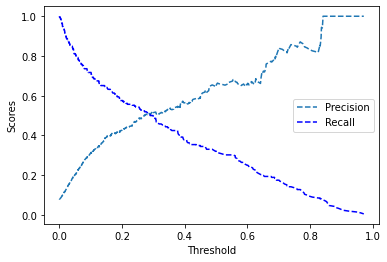

In [ ]:
y_scores=log.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

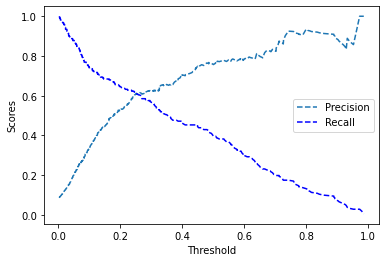

In [ ]:
#forest; grid search 2 vars
classifier = RandomForestClassifier(n_estimators=300, max_depth=30)
classifier.fit(X_train, y_train)
#plot_precision_recall_curve(classifier, X_test, y_test)
y_scores=classifier.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [ ]:
X_train.shape

(6294, 1024)

In [ ]:
def setUpModel(n1=2, n2=2):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=0.99, learning_rate=0.01),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=400, epochs=50)
Kmodel.fit(X_train, y_train)
#plot_precision_recall_curve(Kmodel, X_test, y_test)

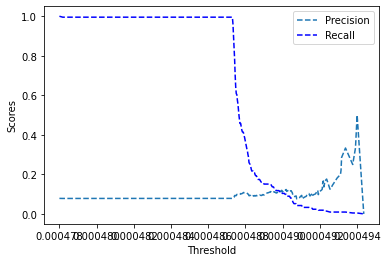

In [ ]:
y_scores=Kmodel.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [ ]:
prec

array([0.07857672, 0.07823508, 0.07826409, 0.0783222 , 0.07835128,
       0.07838039, 0.07843866, 0.07846783, 0.07849702, 0.07852624,
       0.07855547, 0.078908  , 0.07913111, 0.08142494, 0.08415609,
       0.09284116, 0.09353421, 0.09189189, 0.09293948, 0.09815951,
       0.0994295 , 0.1       , 0.09973046, 0.09859155, 0.09920635,
       0.09969168, 0.09979424, 0.1028632 , 0.10186199, 0.10215664,
       0.10377358, 0.10576923, 0.10834371, 0.10727969, 0.10789474,
       0.10762943, 0.10629371, 0.1062591 , 0.10447761, 0.10413476,
       0.10062893, 0.0987055 , 0.0921273 , 0.09262436, 0.09380531,
       0.09272727, 0.08955224, 0.08829175, 0.09108911, 0.09255533,
       0.09034908, 0.09166667, 0.092827  , 0.09032258, 0.09131403,
       0.09382151, 0.09280742, 0.09069212, 0.09046455, 0.0920398 ,
       0.09367089, 0.09536082, 0.09473684, 0.09408602, 0.09289617,
       0.09418283, 0.09550562, 0.09798271, 0.09649123, 0.09552239,
       0.09846154, 0.09968847, 0.10223642, 0.10322581, 0.10491

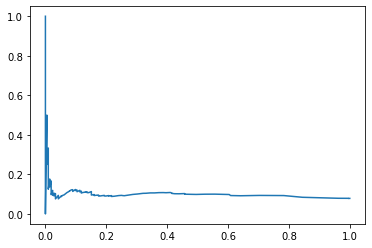

In [ ]:
plt.plot(rec,prec )

## ROC